In [ ]:
import gpytoolbox as gpy
import numpy as np
import trimesh
def yongs_algorithm( points, distances, gradients ):
    '''
    Given a collection of points, where each point has a signed distance value and a gradient.
    For each point, outputs the point -distance units along the gradient direction.
    Parameters:
    points: (N, d) array of point coordinates
        The input points in d-dimensional space.
    distances: (N,) array of signed distance values
        The signed distance values for each point.
    gradients: (N, d) array of gradient vectors
        The gradient vectors at each point.
    '''
    
    # Normalize the gradients to unit vectors
    # norm_gradients = gradients / np.linalg.norm(gradients, axis=1, keepdims=True)
    # Compute the new points by moving along the gradient direction
    new_points = points - (distances[:, np.newaxis] * gradients)
    return new_points


def save_PSR_surface( points, normals, screening_weight = 10.0 ):
    '''
    Runs Poisson Surface Reconstruction to find the surface from the points and normals.
    Parameters:
    points: (N, 3) array of point coordinates
        The input points in 3D space.
    normals: (N, 3) array of normal vectors
        The normal vectors at each point.
    '''
    V,F = gpy.point_cloud_to_mesh( points, normals,
        method='PSR',
        psr_screening_weight=screening_weight,
        psr_outer_boundary_type="Neumann",
        )
    outpath = "out/" + outbase + "_PSR_surface_" + str(num_points) + ".obj"
    gpy.write_mesh( outpath, V, F )
    print( "✅ Saved PSR surface:", outpath )


def save_to_gltf( points, surface_points, gradients, aux=False ):
    '''
    Saves the original points, surface points, and gradients to a GLTF file for visualization.
    Parameters:
    points: (N, 3) array of original point coordinates
        The input points in 3D space.
    surface_points: (N, 3) array of surface point coordinates
        The adjusted points on the surface.
    gradients: (N, 3) array of gradient vectors
        The gradient vectors at each point.
    '''
    # Plot the output using plot2gltf
    try:
        from plot2gltf import GLTFGeometryExporter
    except ImportError:
        print("plot2gltf not installed; skipping visualization.")
        return

    exporter = GLTFGeometryExporter()

    # Big spheres for the surface points
    exporter.add_spheres(surface_points, color=(0, 1, 0), radius = 0.01)  # Green points
    # Small arrows for the gradients
    exporter.add_normal_arrows(
        surface_points, .05*gradients, color=(0, 1, 1),
        shaft_radius=0.002, head_radius=0.004
    )
    if aux:
        # Add auxiliary visualizations if needed
        # Small spheres for the original points
        exporter.add_spheres(points, color=(1, 0, 0), radius = 0.005)  # Red points
        # Small arrows for the original gradients
        exporter.add_normal_arrows(
            points, .05*gradients, color=(1, 1, 0),
            shaft_radius=0.001, head_radius=0.002
        )

        # Add a very thin line from original points to surface points
        exporter.add_lines(
            np.concatenate([points, surface_points], axis=0),
            list(zip( np.arange(len(points)), np.arange(len(points), len(points)*2) )),
            color=(1, 1, 1)
        )

    outpath = "out/" + outbase + "_surface_points_" + str(num_points)
    exporter.save( outpath  + ".gltf")
    
    # # Also save the raw data for easy PSR reconstruction
    # np.savez(outpath + ".npz",
    #          surface_points=surface_points, 
    #          gradients=gradients,
    #          original_points=points)
    print("✅ Saved surface points:", outpath)



In [38]:
# load sdf npz file
data = np.load(r'/Users/yongcheng/Documents/phd/research/sdfgradients/out/bunny_sdf_100000.npz')
outbase = "bunny"
points = data['points']  # (N, 3)
sdf_values = data['sdf_values']  # (N,)
gradients = data['gradients']  # (N, 3)
print("Loaded points shape:", points.shape)
print("Loaded sdf_values shape:", sdf_values.shape)
print("Loaded gradients shape:", gradients.shape)
num_points = points.shape[0]

Loaded points shape: (100000, 3)
Loaded sdf_values shape: (100000,)
Loaded gradients shape: (100000, 3)


In [39]:
# Apply Yong's algorithm to find points on the surface
surface_points = yongs_algorithm(points, sdf_values, gradients)
save_PSR_surface( surface_points, gradients )

✅ Saved PSR surface: out/bunny_PSR_surface_100000.obj


In [4]:
# some sdf data in numpy arrays SDF_POSITIONS, SDF_VALUES
# construct initial mesh
V0, F0 = gpy.icosphere(2)
# call our algorithm
# gpy.reach_for_the_spheres expects an SDF callable; build a fast nearest-neighbor
# interpolant from the sampled `points`->`distances` so we can pass a function.
from scipy.spatial import cKDTree as KDTree
_tree = KDTree(points)
def sdf_callable(q):
    # ensure shape (n,3)
    q = np.asarray(q)
    _, idx = _tree.query(q)
    return sdf_values[idx]
print("sum:", np.sum(sdf_callable(points) - sdf_values))  # verify sdf_callable works

Vr,Fr = gpy.reach_for_the_spheres(points, sdf_callable, V0, F0,
    min_h=0.01,
    remesh_iterations=3,
    verbose=False,
    tol=1e-4)
outpath = "out/" + outbase + "_RFTS_surface_" + str(num_points) + ".obj"
# save the reconstructed mesh
gpy.write_mesh( outpath, Vr, Fr )
print("Saved RFTS/A surface mesh:", outpath)

sum: 0.0
Saved RFTS/A surface mesh: out/bunny_RFTS_surface_7077.obj


In [5]:
Vr, Fr = gpy.reach_for_the_arcs( points, sdf_values)
outpath = "out/" + outbase + "_RFTA_surface_" + str(num_points) + ".obj"

# save the reconstructed mesh
gpy.write_mesh( outpath, Vr, Fr )
print("Saved RFTS/A surface mesh:", outpath)

Saved RFTS/A surface mesh: out/bunny_RFTA_surface_7077.obj


In [40]:
def estimate_gradient(points, sdf_values):
    """ estimation of gradients from SDF values at given points."""
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=24, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(points)
    gradients = np.zeros_like(points)
    for i in range(points.shape[0]):
        neighbor_points = points[indices[i]]
        neighbor_sdf = sdf_values[indices[i]]
        diffs = neighbor_points - points[i]
        sdf_diffs = neighbor_sdf - sdf_values[i]
        A = diffs
        b = sdf_diffs
        grad, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        gradients[i] = grad
    # Normalize gradients
    norms = np.linalg.norm(gradients, axis=1, keepdims=True)
    gradients /= np.maximum(norms, 1e-8)
    return gradients


In [41]:
my_grad = estimate_gradient(points, sdf_values)
print("Estimated gradients shape:", my_grad.shape)

Estimated gradients shape: (100000, 3)


In [42]:
# Apply Yong's algorithm to find points on the surface
surface_points = yongs_algorithm(points, sdf_values, my_grad)
save_PSR_surface( surface_points, my_grad )
save_to_gltf( points, surface_points, my_grad, aux=False )

✅ Saved PSR surface: out/bunny_PSR_surface_100000.obj
✅ Saved surface points: out/bunny_surface_points_100000


In [62]:
import igl
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

def generate_test_mesh_data( path_to_mesh, outbase, num_points=500 ):
    '''
    Loads a mesh from the given path and computes signed distances and gradients for its vertices.
    Parameters:
    path_to_mesh: str
        The file path to the mesh.
    Returns:
    points: (N, 3) array of vertex coordinates
        The vertices of the mesh.
    distances: (N,) array of signed distance values
        The signed distance values for each vertex.
    gradients: (N, 3) array of gradient vectors
        The gradient vectors at each vertex.
    '''
    import trimesh

    # Load the mesh
    mesh = trimesh.load(path_to_mesh)
    # Normalize the mesh to fit within a unit cube
    min = np.min( mesh.vertices, axis=0 )
    max = np.max( mesh.vertices, axis=0 )
    mesh.vertices -= (min + max) / 2
    mesh.vertices /= np.max( max - min )

    # # Generate random points in 3D space
    # radius = 2*np.max( np.linalg.norm( mesh.vertices, axis=1 ) )
    # points = np.random.uniform(-radius, radius, (num_points, 3))

    # Generate equally spaced points around the mesh bounding box
    bbox_min = np.min(mesh.vertices, axis=0) - 0.1
    bbox_max = np.max(mesh.vertices, axis=0) + 0.1
    grid_size = int(np.ceil(num_points ** (1/3)))
    x = np.linspace(bbox_min[0], bbox_max[0], grid_size)
    y = np.linspace(bbox_min[1], bbox_max[1], grid_size)
    z = np.linspace(bbox_min[2], bbox_max[2], grid_size)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
    if points.shape[0] > num_points:
        points = points[np.random.choice(points.shape[0], num_points, replace=False)]
    # Find the closest points on the mesh surface
    V = np.asarray(mesh.vertices, dtype=np.float64)
    F = np.asarray(mesh.faces, dtype=np.int32)
    sq_dists, face_ids, closest = igl.point_mesh_squared_distance(points, V, F)
    distances = np.sqrt(sq_dists)

    gradients = points - closest
    # Normalize gradients
    norm_temp = np.linalg.norm(gradients, axis=1, keepdims=True)
    # Avoid division by zero
    norm_temp[np.abs(norm_temp) <= 1e-8] = 1.0
    gradients /= norm_temp

    # Filter out points that are too close to the surface (within 0.1 units), also remove respective gradients
    mask = np.abs(distances) > 1e-8
    points = points[mask]
    distances = distances[mask]
    gradients = gradients[mask]

    # Use winding number to determine inside/outside
    W = igl.winding_number(V, F, points)
    mask = W > 0.5  # Points with winding number > 0.5 are inside
    distances[mask] *= -1.0  # Invert distances for points inside the mesh
    gradients[mask] *= -1.0  # Invert gradients for points inside the mesh

    # save to file for reuse
    np.savez("out/" + outbase + "_sdf_" + str(num_points) + ".npz",
             points=points,
             sdf_values=distances,
             gradients=gradients)
    print("✅ Saved SDF data:", "out/" + outbase + "_sdf_" + str(num_points) + ".npz")
    return points, distances, gradients

class Interpolator:
    """
    A Duchon interpolator to fit and predict values based on input signed distance data.
    """
    def __init__(self, kernel):
        """
        define the radial basis function for Duchon interpolation.
        
        :param self: Description
        :param kernel: Description
        """
        self.points = None
        self.values = None
        self.alpha = None
        self.p = None
        self.q = None
        if kernel == 'thin_plate':
            self.kernel = lambda r: r**2 * np.log(r + 1e-10)  # Adding a small value to avoid log(0)
        else:
            self.kernel = lambda r: r**3  # Default to cubic kernel

    def fit(self, points, values):
        """
        Fit the interpolator with given points and their corresponding values.

        Parameters:
        points (np.ndarray): An array of shape (n_samples, m_dimensions) representing the input points.
        values (np.ndarray): An array of shape (n_samples,) representing the values at the input points.
        """
        self.points = points
        self.values = values
        self.alpha, self.p, self.q = self._compute_coefficients(points, values)

    def _compute_coefficients(self, points, values):
        """
        Compute the coefficients for the Duchon interpolation based on the input points and values.
        Parameters:
        points (np.ndarray): An array of shape (n_samples, m_dimensions) representing the input points.
        values (np.ndarray): An array of shape (n_samples,) representing the values at the input points.
        
        Returns:
        tuple: A tuple containing the coefficients for the radial basis functions and polynomial terms.
        """
        # construct the interpolation matrix
        n_samples = points.shape[0]
        m_dimensions = points.shape[1]
        K = np.zeros((n_samples + m_dimensions + 1, n_samples + m_dimensions + 1))
        for i in range(n_samples):
            for j in range(n_samples):
                r = np.linalg.norm(points[i] - points[j])
                if r == 0:
                    K[i, j] = 0
                else:
                    K[i, j] = self.kernel(r)
        # Add polynomial terms for Duchon interpolation
        P = np.ones((n_samples, m_dimensions + 1))
        P[:, :-1] = points
        K[:n_samples, n_samples:] = P
        K[n_samples:, :n_samples] = P.T
        y = np.zeros(n_samples + m_dimensions + 1)
        y[:n_samples] = values
        # Solve for coefficients
        coefficients = np.linalg.solve(K, y)
        return coefficients[:n_samples], coefficients[n_samples:-1], coefficients[-1]

    def predict(self, x_new):
        """
        Predict values at new input points using the fitted interpolator. Duchon interpolation multiplies all basis
        functions by a coefficient term. The basis functions are radial basis functions that depend on the distance
        between points.

        Parameters:
        x_new (np.ndarray): An array of shape (m_samples, dimensions) representing the new input points.

        Returns:
        np.ndarray: An array of shape (m_samples,) representing the predicted values at the new points.
        """
        n_samples = self.points.shape[0]
        m_samples = x_new.shape[0]
        distances = cdist(x_new, self.points, metric='euclidean')
        r = self.kernel(distances)  # Apply kernel to all distances at once
        return r @ self.alpha + x_new @ self.p + self.q
    
# Example usage:
def test_circle():
        # Generate a signed distance field for a circle. 
    # Sample data points and values. 16 points in grid corners in 2D
    num_points = 16
    points = np.array([[x, y] for x in np.linspace(0, 1, 4) for y in np.linspace(0, 1, 4)])
    values = np.sqrt((points[:, 0] - 0.5)**2 + (points[:, 1] - 0.5)**2) - 0.3  # Signed distance from circle of radius 0.3 centered at (0.5, 0.5)    

    # Create and fit the interpolator
    interpolator = Interpolator(kernel='thin_plate')
    interpolator.fit(points, values)

    # visualize results in 2D as heatmap
    grid_x, grid_y = np.mgrid[-0.5:1.5:100j, -0.5:1.5:100j]
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
    grid_values = interpolator.predict(grid_points).reshape(100, 100)
    plt.imshow(grid_values.T, extent=(-0.5, 1.5, -0.5, 1.5), origin='lower', cmap='viridis')
    plt.colorbar(label='Interpolated Values')
    plt.scatter(points[:, 0], points[:, 1], c='red', label='Data Points')
    plt.legend()
    plt.title('Duchon Interpolation Heatmap')
    plt.show()

def test_sphere():
    # Generate a signed distance field for a sphere.
    points = np.array([[x, y, z] for x in np.linspace(0, 1, 5) for y in np.linspace(0, 1, 5) for z in np.linspace(0, 1, 5)])
    values = np.sqrt((points[:, 0] - 0.5)**2 + (points[:, 1] - 0.5)**2 + (points[:, 2] - 0.5)**2) - 0.3  # Signed distance from sphere of radius 0.3 centered at (0.5, 0.5, 0.5)    

    # Create and fit the interpolator
    interpolator = Interpolator(kernel='cubic')
    interpolator.fit(points, values)

    # visualize results using marching cubes to extract isosurface
    grid_resolution = 50
    grid_x, grid_y, grid_z = np.mgrid[-0.5:1.5:grid_resolution*1j, -0.5:1.5:grid_resolution*1j, -0.5:1.5:grid_resolution*1j]
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T
    grid_values = interpolator.predict(grid_points).reshape(grid_resolution, grid_resolution, grid_resolution)
    
    # Extract isosurface at value 0 using marching cubes
    from skimage import measure
    verts, faces, normals, values = measure.marching_cubes(grid_values, level=0.0, spacing=(2.0/grid_resolution, 2.0/grid_resolution, 2.0/grid_resolution))
    
    # Adjust vertices to match the grid coordinates
    verts = verts - 0.5
    
    # Plot the mesh
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.7, edgecolor='k', linewidth=0.1)
    mesh.set_facecolor([0.5, 0.7, 1.0])
    ax.add_collection3d(mesh)
    
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_zlim(-0.5, 1.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Isosurface Extraction (Marching Cubes)')
    plt.show()

def test_mesh(path_to_sdf='out/bunny_sdf_4000.npz'):
    # read sdf data from file
    data = np.load(path_to_sdf)
    points = data['points']
    distances = data['sdf_values']

    # Create and fit the interpolator
    interpolator = Interpolator(kernel='cubic')
    interpolator.fit(points, distances)

    # Predict at new points (for example, the original points)
    predictions = interpolator.predict(points)
    print("Predictions at original points:", predictions[:10])  # Print first 10 predictions

    # visualize results using marching cubes to extract isosurface
    grid_resolution = 50
    grid_x, grid_y, grid_z = np.mgrid[-0.5:1.5:grid_resolution*1j, -0.5:1.5:grid_resolution*1j, -0.5:1.5:grid_resolution*1j]
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T
    grid_values = interpolator.predict(grid_points).reshape(grid_resolution, grid_resolution, grid_resolution)
    
    # Extract isosurface at value 0 using marching cubes
    from skimage import measure
    verts, faces, normals, values = measure.marching_cubes(grid_values, level=0.0, spacing=(2.0/grid_resolution, 2.0/grid_resolution, 2.0/grid_resolution))
    
    # Adjust vertices to match the grid coordinates
    verts = verts - 0.5
    
    # Plot the mesh
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.7, edgecolor='k', linewidth=0.1)
    mesh.set_facecolor([0.5, 0.7, 1.0])
    ax.add_collection3d(mesh)
    
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_zlim(-0.5, 1.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Isosurface Extraction (Marching Cubes)')
    plt.show()

def generate_2D_mesh(n=4, visualize=False):
    # read image and generate 2D mesh data from examples/image.png
    from skimage import io, color, measure
    image = io.imread('examples/image.png')
    # image shape = (H, W, 4)
    gray_image = color.rgb2gray(image[:, :, :3])  # Convert to grayscale
    # Extract contours at a constant value of 0.5
    contours = measure.find_contours(gray_image, level=0.5)
    # Use the longest contour
    longest_contour = max(contours, key=len)
    points = longest_contour[:, ::-1]  # Swap columns to get (x, y)
    points /= np.max(points)  # Normalize to [0, 1]
    points[:, 1] = 1.0 - points[:, 1]  # Flip y-axis
    values = np.zeros(points.shape[0])

    # visualize the 2D shape
    if visualize:
        plt.figure(figsize=(6, 6))
        plt.plot(points[:, 0], points[:, 1], 'b-', linewidth=2)
        plt.fill(points[:, 0], points[:, 1], 'lightblue', alpha=0.5)
        plt.axis('equal')
        plt.title('2D Shape from Image Contour')
    plt.show()
    # Compute signed distance values (inside/outside)
    # Sample data points and values. 16 points in grid corners in 2D
    sdf_points = np.array([[x, y] for x in np.linspace(0, 1, n) for y in np.linspace(0, 1, n)])
    # compute signed distance values to the 2D shape
    from matplotlib.path import Path
    shape_path = Path(longest_contour[:, ::-1] / np.max(longest_contour))  # Create a path for the shape
    def signed_distance(pt):
        dist = np.min(np.linalg.norm(longest_contour[:, ::-1] / np.max(longest_contour) - pt, axis=1))
        if shape_path.contains_point(pt):
            return -dist  # Inside the shape
        else:
            return dist  # Outside the shape
    values = np.array([signed_distance(pt) for pt in sdf_points])

    return points, sdf_points, values

def test_2D_mesh(interpolator=None, n=4):
    points, sdf_points, values = generate_2D_mesh(n=n, visualize=False)
    if interpolator is None:
        # Create and fit the interpolator
        interpolator = Interpolator(kernel='thin_plate')
        interpolator.fit(sdf_points, values)
    # visualize results in 2D as heatmap
    fig, ax = plt.subplots(figsize=(8, 7))
    grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
    grid_values = interpolator.predict(grid_points).reshape(100, 100)
    im = ax.imshow(grid_values.T, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
    plt.colorbar(im, ax=ax, label='Interpolated SDF Values')
    # overlay the original shape
    ax.plot(points[:, 0], points[:, 1], 'w-', linewidth=1, label='Original Shape')
    # draw the contours at multiple levels (no transpose for contour!)
    contour_levels = np.linspace(np.min(grid_values), np.max(grid_values), 10)
    # insert 0 level contour if not in levels
    if 0.0 not in contour_levels:
        contour_levels = np.sort( np.append( contour_levels, 0.0 ) )
    ax.contour(grid_x, grid_y, grid_values, levels=contour_levels, colors='yellow', linewidths=0.5, alpha=0.5)
    # make 0-level contour distinct
    ax.contour(grid_x, grid_y, grid_values, levels=[0.0], colors='red', linewidths=1)
    # compute interpolation errors: original values - predicted values
    predicted_values = interpolator.predict(sdf_points)
    errors = np.abs(values - predicted_values)
    # show data points with error as color (darker = larger error)
    scatter = ax.scatter(sdf_points[:, 0], sdf_points[:, 1], c=errors, s=10, cmap='hot', 
                         edgecolors='black', linewidths=0.5, label='Data Points')
    plt.colorbar(scatter, ax=ax, label='|True - Interpolated|')
    ax.set_title('Duchon Interpolation Heatmap for 2D Shape' + ' (' + str(n) + '^2 points)')
    # ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    return interpolator

/Users/yongcheng/Documents/phd/research/sdfgradients/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/yongcheng/Documents/phd/research/sdfgradients/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/yongcheng/Documents/phd/research/sdfgradients/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs
/var/folders/t8/sqbkxz497_595gspb0r1f8cr0000gn/T/ipykernel_22289/3746044707.py:159: RuntimeWarning: divide by zero encountered in matmul
  return r @ self.alpha + x_new @ self.p + self.q
/var/folders/t8/sqbkxz497_595gspb0r1f8cr0000gn/T/ipykernel_22289/3746044707.py:159: RuntimeWarning: overflow encountered in matmul
  return r @ self.alpha + x_new @ self.p + self.q
/var/folders/t8/sqbkxz497_595gspb0r1f8cr0000gn/T/ipyke

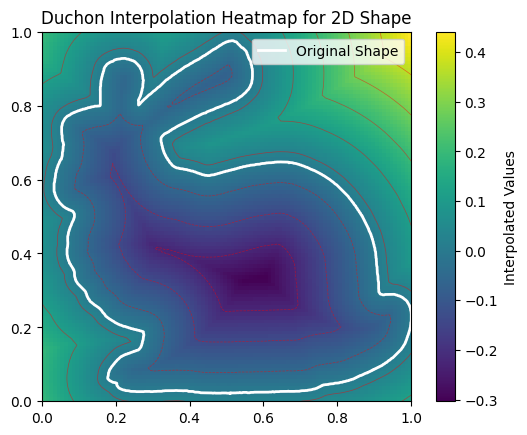

In [20]:
interpolator = test_2D_mesh(interpolator, n=100)

In [63]:
%matplotlib qt
interpolator10 = test_2D_mesh(n=30)

/Users/yongcheng/Documents/phd/research/sdfgradients/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/yongcheng/Documents/phd/research/sdfgradients/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/yongcheng/Documents/phd/research/sdfgradients/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs
/var/folders/t8/sqbkxz497_595gspb0r1f8cr0000gn/T/ipykernel_22289/3523614913.py:159: RuntimeWarning: divide by zero encountered in matmul
  return r @ self.alpha + x_new @ self.p + self.q
/var/folders/t8/sqbkxz497_595gspb0r1f8cr0000gn/T/ipykernel_22289/3523614913.py:159: RuntimeWarning: overflow encountered in matmul
  return r @ self.alpha + x_new @ self.p + self.q
/var/folders/t8/sqbkxz497_595gspb0r1f8cr0000gn/T/ipyke

/Users/yongcheng/Documents/phd/research/sdfgradients/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/yongcheng/Documents/phd/research/sdfgradients/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/yongcheng/Documents/phd/research/sdfgradients/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs
/var/folders/t8/sqbkxz497_595gspb0r1f8cr0000gn/T/ipykernel_22289/1561765047.py:159: RuntimeWarning: divide by zero encountered in matmul
  return r @ self.alpha + x_new @ self.p + self.q
/var/folders/t8/sqbkxz497_595gspb0r1f8cr0000gn/T/ipykernel_22289/1561765047.py:159: RuntimeWarning: overflow encountered in matmul
  return r @ self.alpha + x_new @ self.p + self.q
/var/folders/t8/sqbkxz497_595gspb0r1f8cr0000gn/T/ipyke

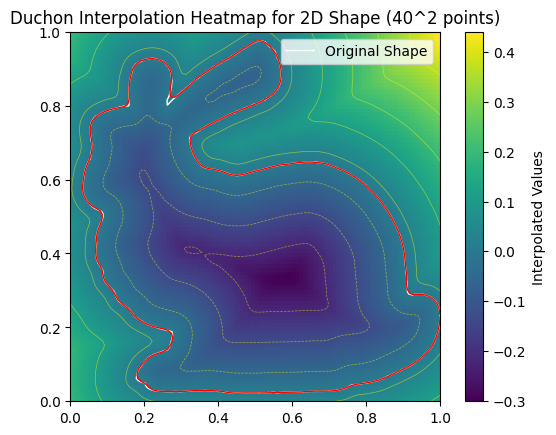

In [42]:
interpolator10 = test_2D_mesh(n=40)